In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import colors

In [2]:
import numpy as np 
import pandas as pd 
import xarray as xr

In [3]:
from datetime import datetime

In [4]:
from cartopy import crs as ccrs
from cartopy import feature as cfeature 
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

### import palettable for nice colormaps (see https://jiffyclub.github.io/palettable/) 

In [5]:
import palettable

### read the CMAP dataset

In [6]:
dset = xr.open_dataset('../data/CMAP/precip.mon.mean.nc')

In [7]:
dset = dset.sortby('lat')

### calculates the climatology 

In [8]:
clim = dset.sel(time=slice('1991','2020'))

In [9]:
clim = clim.groupby(clim.time.dt.month).mean('time')

### calculate the anomalies 

In [10]:
dset_anoms = dset.groupby(dset.time.dt.month) - clim

### interpolate ?

In [11]:
def interp(dset, interp_factor=4, lon_name='lon', lat_name='lat'): 
    """
    Interpolate (i.e. increase the resolution) of a xarray dataset by `interp_factor`
    Parameters
    ----------
    dset : xarray.Dataset
        the xarray Dataset to interpolate
    interp_factor : int, optional
        the increase in resolution, by default 4
    lon_name : str, optional
        name of the longitude variable, by default 'lon'
    lat_name : str, optional
        name of the latitude variable, by default 'lat'
    
    Return
    ------
    
    dset : the interpolated dataset 
    """
    
    import numpy as np 
    
    target_grid = dset[[lon_name, lat_name]]
    
    target_grid[lon_name] = ((lon_name), np.linspace(target_grid[lon_name].data[0], target_grid[lon_name].data[-1], num=len(target_grid[lon_name])*interp_factor, endpoint=True))
    target_grid[lat_name] = ((lat_name), np.linspace(target_grid[lat_name].data[0], target_grid[lat_name].data[-1], num=len(target_grid[lat_name])*interp_factor, endpoint=True))
    
    dset = dset.interp_like(target_grid)
    
    return dset

In [12]:
dset = interp(dset)

In [13]:
dset_anoms = interp(dset_anoms)

### restrict the domain to [110.,-40.,280.,40.] 

In [14]:
dset = dset.sel(lat=slice(-40., 40.), lon=slice(110, 280))

In [15]:
dset_anoms = dset_anoms.sel(lat=slice(-40., 40.), lon=slice(110, 280))

### quick plots the anomalies for January 2019

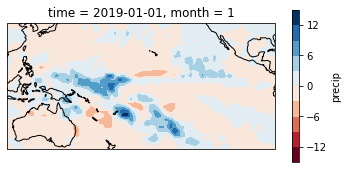

In [16]:
f, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
dset_anoms.sel(time='2019-01')['precip'][0,:,:].plot.contourf(transform=ccrs.PlateCarree(), levels=10, cmap=plt.cm.RdBu, cbar_kwargs={'shrink':0.7})
ax.coastlines()
cb = f.axes[1]

### Now proper map plot 

### define here the plotting functions

In [17]:
def plot_map(dataset, date, varname='precip', fname=None, units="Rainfall anomalies (mm.day$^{-1}$)", title=None, vmin=-12, vmax=12, step=2, cmap=plt.cm.RdBu_r, norm=None, contour=None, colors=None):
    
    f, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)}, figsize=(12,10))

    if norm is not None: 
    
        im = ax.contourf(dataset.lon, dataset.lat, dataset.sel(time=date)[varname], \
                         transform = ccrs.PlateCarree(central_longitude=0), \
                         levels = np.arange(vmin, vmax + step, step), \
                         extend = 'both', \
                         cmap = cmap, norm=norm)
    else:
        
        im = ax.contourf(dataset.lon, dataset.lat, dataset.sel(time=date)[varname], \
                         transform = ccrs.PlateCarree(central_longitude=0), \
                         levels = np.arange(vmin, vmax + step, step), \
                         extend = 'both', \
                         cmap = cmap, norm=norm)

    if contour is not None: 
        
        if type(contour) is not list: 
            contour = [contour]
            
        if colors is None: 
            colors = 'k'
        
        cb = ax.contour(dataset.lon, dataset.lat, dataset.sel(time=date)[varname], \
                         transform = ccrs.PlateCarree(central_longitude=0), \
                         levels = contour, colors=colors)
        
    cb = plt.colorbar(im, shrink=0.8, pad=0.09, orientation='horizontal', aspect=30)

    cb.set_label(units, fontsize=14)

    [l.set_fontsize(13) for l in cb.ax.xaxis.get_ticklabels()]

    xticks = np.arange(0, 360, 40)
#     xticks = np.arange(0, 360, 10)

    yticks = [-30., 0, 30.]
#     yticks = np.arange(-40, 50, 10)

    gl = ax.gridlines(draw_labels=False, linewidth=0., linestyle='--', xlocs=xticks, ylocs=yticks, crs=ccrs.PlateCarree())

    ax.set_xticks(xticks, crs=ccrs.PlateCarree())

    ax.set_yticks(yticks, crs=ccrs.PlateCarree())

    ax.coastlines(resolution='50m', zorder=10, lw=1)

    lon_formatter = LongitudeFormatter(zero_direction_label=True, dateline_direction_label=True) 

    lat_formatter = LatitudeFormatter()

    ax.xaxis.set_major_formatter(lon_formatter)

    ax.yaxis.set_major_formatter(lat_formatter)

    #     [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]
    #     [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]

    [l.set_fontsize(10) for l in ax.yaxis.get_ticklabels()]
    [l.set_fontsize(10) for l in ax.xaxis.get_ticklabels()]
    
    ax.set_extent([dataset.lon.data.min(), dataset.lon.data.max(), dataset.lat.data.min(), dataset.lat.data.max()], crs=ccrs.PlateCarree())

    if title is not None: 
        ax.set_title(title, fontsize=14) 

    if fname is not None: 
        f.savefig(fname, dpi=400, bbox_inches='tight', facecolor='w')  
        f.savefig(fname.replace(".png",".ps"), facecolor='w')
        f.savefig(fname.replace(".png",".pdf"), facecolor='w')
        f.savefig(fname.replace(".png",".svg"), facecolor='w')

In [18]:
def plot_clim(dataset, month, varname='precip', fname=None, units="Rainfall (mm.day$^{-1}$)", title=None, vmin=-12, vmax=12, step=2, contour=10, colors=None, cmap=plt.cm.RdBu_r, norm=None):
        
    f, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)}, figsize=(12,10))

    if norm is not None: 
    
        im = ax.contourf(dataset.lon, dataset.lat, dataset.sel(month=month)[varname], \
                         transform = ccrs.PlateCarree(central_longitude=0), \
                         levels = np.arange(vmin, vmax + step, step), \
                         extend = 'both', \
                         cmap = cmap, norm=norm)
    else:
        
        im = ax.contourf(dataset.lon, dataset.lat, dataset.sel(month=month)[varname], \
                         transform = ccrs.PlateCarree(central_longitude=0), \
                         levels = np.arange(vmin, vmax + step, step), \
                         extend = 'both', \
                         cmap = cmap, norm=norm)
    
    if contour is not None: 
        
        if type(contour) is not list: 
            contour = [contour]
 
        if colors is None: 
            colors = 'k'
        
        cb = ax.contour(dataset.lon, dataset.lat, dataset.sel(month=month)[varname], \
                         transform = ccrs.PlateCarree(central_longitude=0), \
                         levels = contour, colors=colors)       

    cb = plt.colorbar(im, shrink=0.8, pad=0.09, orientation='horizontal', aspect=30)

    cb.set_label(units, fontsize=14)

    [l.set_fontsize(13) for l in cb.ax.xaxis.get_ticklabels()]

    xticks = np.arange(0, 360, 40)
#     xticks = np.arange(0, 360, 10)

    yticks = [-30., 0, 30.]
#     yticks = np.arange(-40, 50, 10)

    gl = ax.gridlines(draw_labels=False, linewidth=0., linestyle='--', xlocs=xticks, ylocs=yticks, crs=ccrs.PlateCarree())

    ax.set_xticks(xticks, crs=ccrs.PlateCarree())

    ax.set_yticks(yticks, crs=ccrs.PlateCarree())

    ax.coastlines(resolution='50m', zorder=10, lw=1)

    lon_formatter = LongitudeFormatter(zero_direction_label=True, dateline_direction_label=True) 

    lat_formatter = LatitudeFormatter()

    ax.xaxis.set_major_formatter(lon_formatter)

    ax.yaxis.set_major_formatter(lat_formatter)

    #     [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]
    #     [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]

    [l.set_fontsize(10) for l in ax.yaxis.get_ticklabels()]
    [l.set_fontsize(10) for l in ax.xaxis.get_ticklabels()]
    
    ax.set_extent([dataset.lon.data.min(), dataset.lon.data.max(), dataset.lat.data.min(), dataset.lat.data.max()], crs=ccrs.PlateCarree())

    if title is not None: 
        ax.set_title(title, fontsize=14) 

    if fname is not None: 
        f.savefig(fname, dpi=400, bbox_inches='tight', facecolor='w')
        f.savefig(fname.replace(".png",".ps"), facecolor='w')
        f.savefig(fname.replace(".png",".pdf"), facecolor='w')

In [19]:
data_to_plot = dset_anoms

### choose the date for the plot here 

In [20]:
varname = 'precip'

In [21]:
vmin = -12
vmax = 12 
step = 2
center = 0

In [22]:
units = "Rainfall anomalies (mm.day$^{-1}$)"

In [23]:
cmap = palettable.lightbartlein.diverging.BlueDarkRed18_9_r

In [24]:
cmap = cmap.mpl_colormap

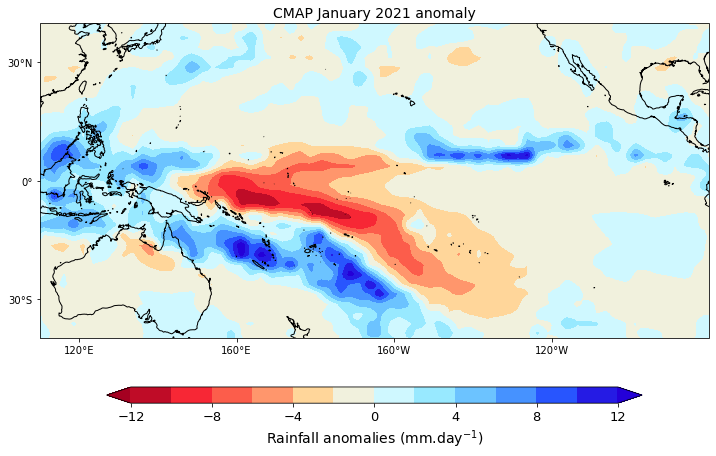

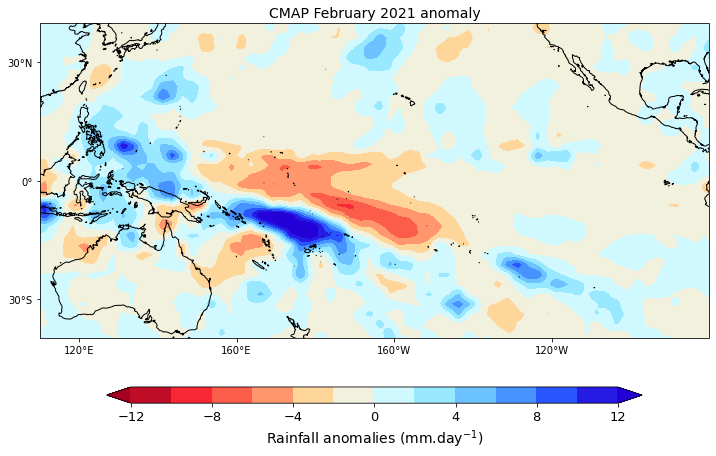

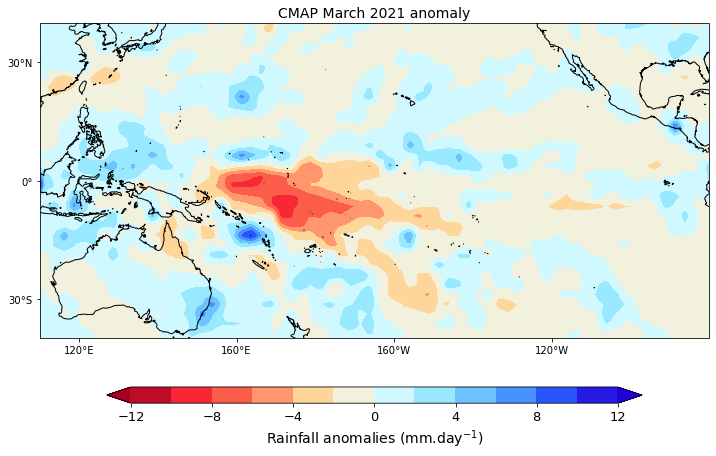

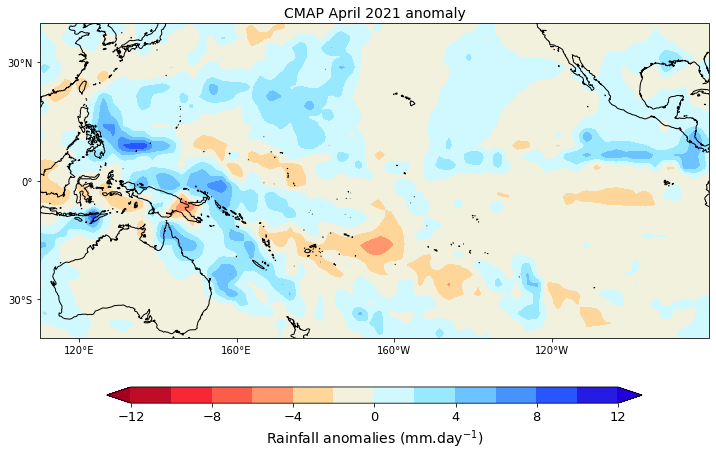

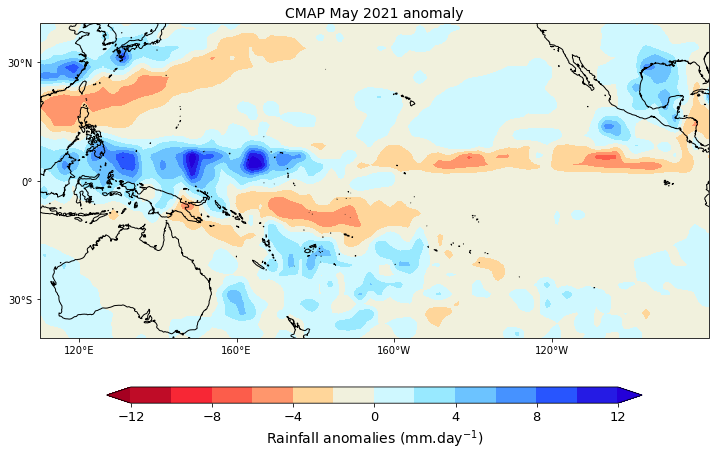

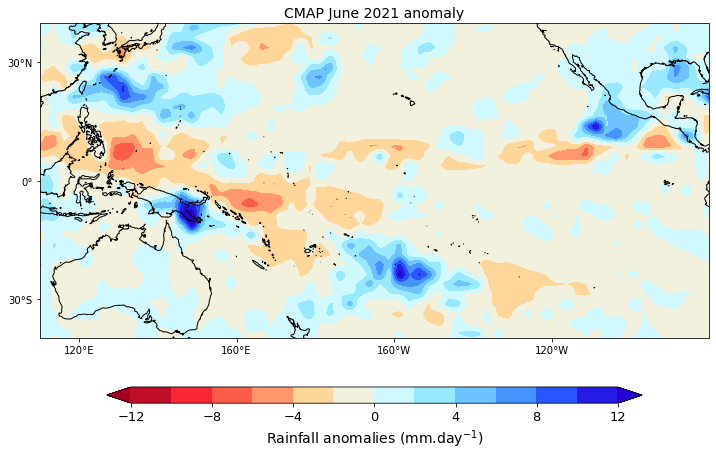

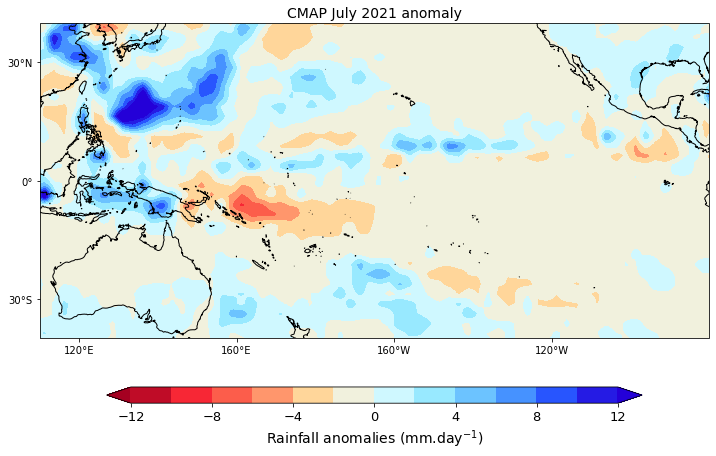

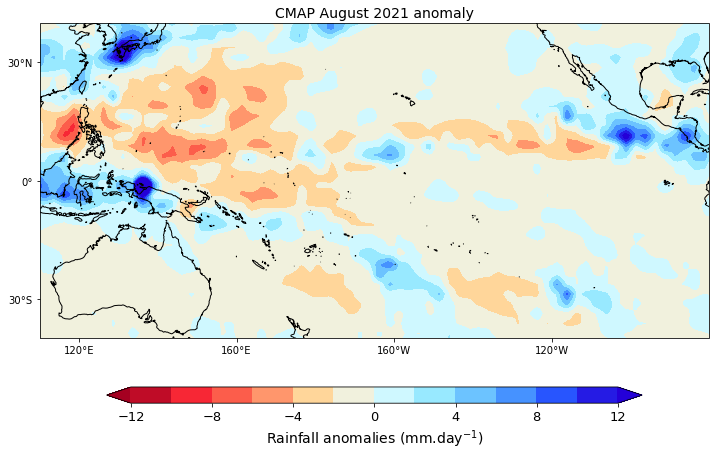

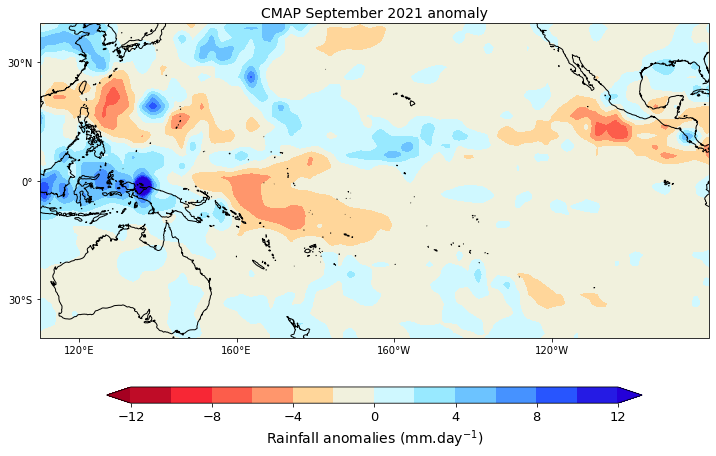

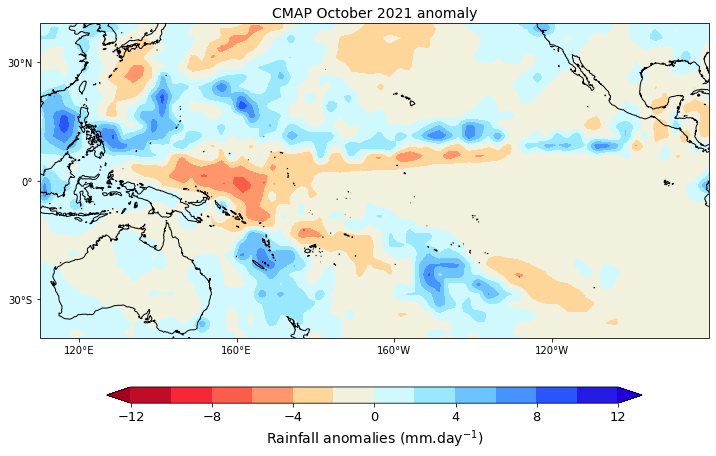

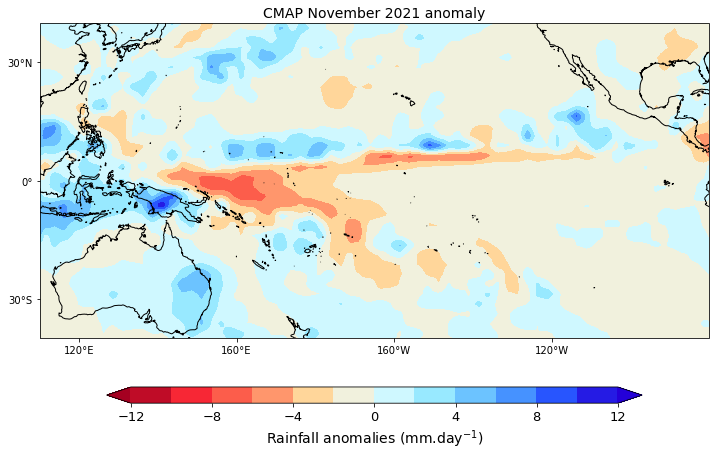

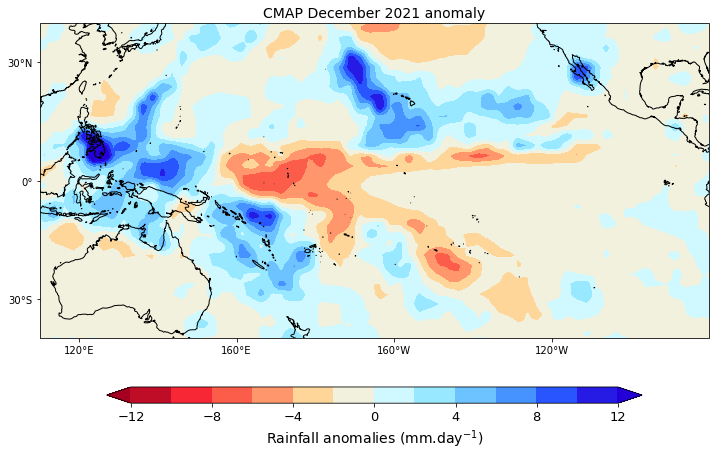

In [25]:
for date in pd.date_range(start='2021-01-01', end='2021-12-01', freq='MS'): 
    title = f"CMAP {date:%B %Y} anomaly"
    fname = f"../figures/CMAP_anomaly_mm_{date:%Y-%m}_paper.png" 
    plot_map(dset_anoms, date, varname=varname, title=title, fname=fname, units=units, cmap=cmap, vmin=vmin, vmax=vmax, step=step)

### calculates the 3 months averages of the anomalies 

In [26]:
dset_anoms_rm = dset_anoms.rolling({'time':3}, center=False, min_periods=3).mean('time')

In [27]:
dset_anoms_rm = dset_anoms_rm.isel(time=slice(2, None))

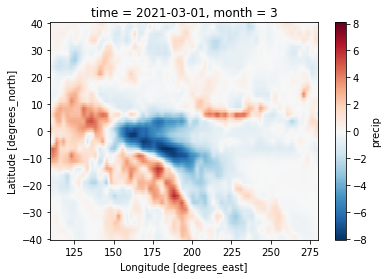

In [28]:
dset_anoms_rm.sel(time='2021-03-01')['precip'].plot()

In [29]:
varname = 'precip'

In [30]:
vmin = -8
vmax = 8
step = 1
center = 0

In [31]:
units = "Rainfall anomalies (mm.day$^{-1}$)"

In [32]:
cmap = palettable.lightbartlein.diverging.BlueDarkRed18_9_r

In [33]:
cmap = cmap.mpl_colormap

In [34]:
title = f"CMAP, January - March 2021 anomaly"

In [35]:
fname = f"../figures/CMAP_anomaly_mm_JFM2021_paper.png"

In [36]:
date = '2021-03-01'

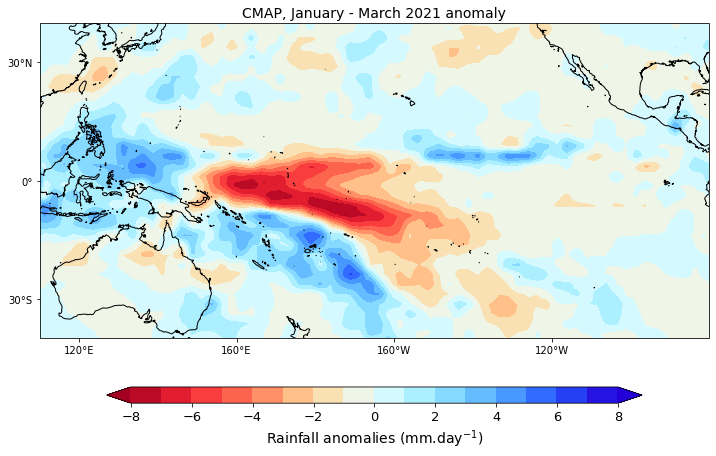

In [37]:
plot_map(dset_anoms_rm, date, varname=varname, title=title, fname=fname, units=units, cmap=cmap, vmin=vmin, vmax=vmax, step=step)

### anomalies in percentage of normal 

In [29]:
dset

<xarray.Dataset>
Dimensions:  (time: 516, lat: 130, lon: 274)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
  * lon      (lon) float64 110.1 110.7 111.3 111.9 ... 277.9 278.5 279.2 279.8
  * lat      (lat) float64 -39.89 -39.27 -38.65 -38.04 ... 38.65 39.27 39.89
Data variables:
    precip   (time, lat, lon) float64 0.9317 0.9224 0.9136 ... 2.716 2.438 2.078
Attributes:
    Conventions:    COARDS
    title:          CPC Merged Analysis of Precipitation (excludes NCEP Reana...
    platform:       Analyses
    source:         ftp ftp.cpc.ncep.noaa.gov precip/cmap/monthly
    dataset_title:  CPC Merged Analysis of Precipitation
    documentation:  https://www.esrl.noaa.gov/psd/data/gridded/data.cmap.html
    date_modified:  26 Feb 2019
    References:     https://www.psl.noaa.gov/data/gridded/data.cmap.html
    version:        V2201
    history:        update 01/2022 V2201
    data_modified:  2022-01-10

In [30]:
clim

<xarray.Dataset>
Dimensions:  (lat: 72, lon: 144, month: 12)
Coordinates:
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip   (month, lat, lon) float32 0.5167 0.5353 0.5497 ... nan nan nan

In [31]:
dset_pp = dset.copy()

In [34]:
dset_pp = dset_pp.merge(clim.rename({'precip':'clim'}), compat='override')

In [36]:
def make_anoms_pp(dset): 
    return (dset['precip'] - dset['clim']) / dset['clim'] * 100.

In [37]:
anoms_pp = dset_pp.groupby(dset_pp.time.dt.month).apply(make_anoms_pp)

In [38]:
anoms_pp = anoms_pp.to_dataset(name='prcp')

In [39]:
vmin = 0
vmax = 400 
step = 10

### set the mid point for the diverging colormap at 100 % 

In [40]:
mid_point = 100

In [41]:
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=mid_point, vmax=vmax)

In [42]:
# norm = colors.DivergingNorm(vmin=vmin, vcenter=mid_point, vmax=vmax)

In [43]:
units = "Rainfall anomalies (% Normal)"

In [44]:
cmap = palettable.lightbartlein.diverging.BlueDarkRed18_9_r

In [45]:
cmap = cmap.mpl_colormap

In [46]:
# for date in pd.date_range(start='2020-01-01', end='2020-12-01', freq='MS'): 
#     title = f"CMORPH {date:%B %Y} % of Normal"
#     fname = f"../figures/CMORPH_anomaly_percent_{date:%Y-%m}_paper.png"
#     plot_map(anoms_pp, date, varname=varname, title=title, fname=fname, units=units, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, step=step)

### Now just plots the monthly average value 

In [47]:
varname = 'precip'

In [48]:
vmin = 0
vmax = 20 
step = 1

In [49]:
units="Rainfall (mm.day$^{-1}$)"

In [50]:
cmap = palettable.lightbartlein.sequential.Blues7_7

In [51]:
cmap = cmap.mpl_colormap

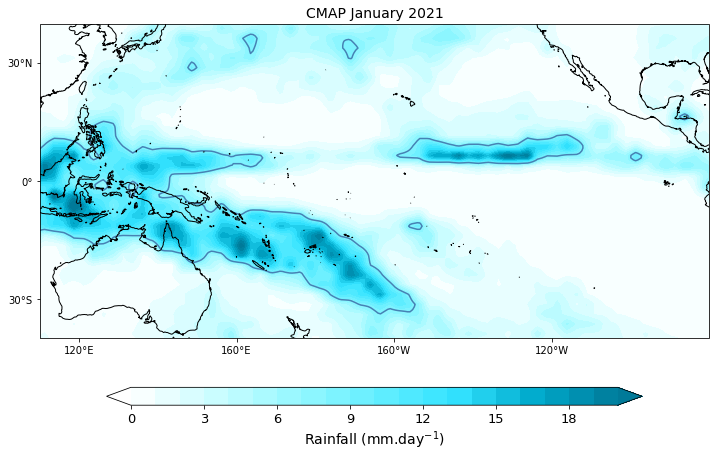

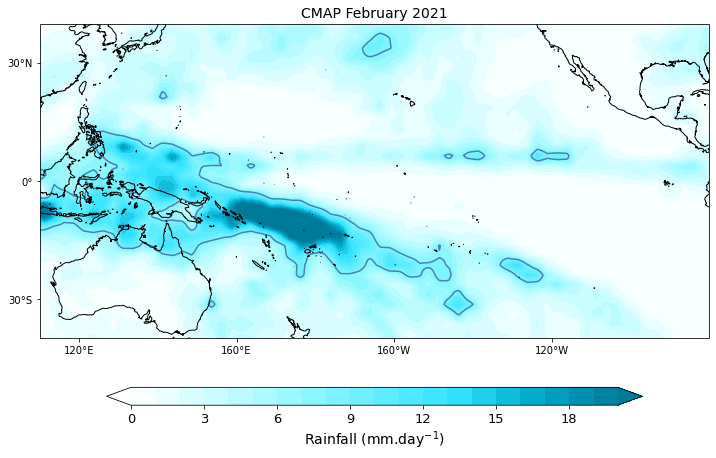

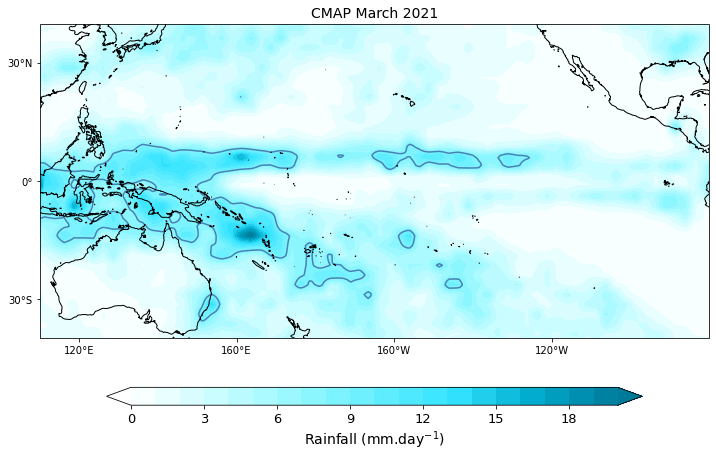

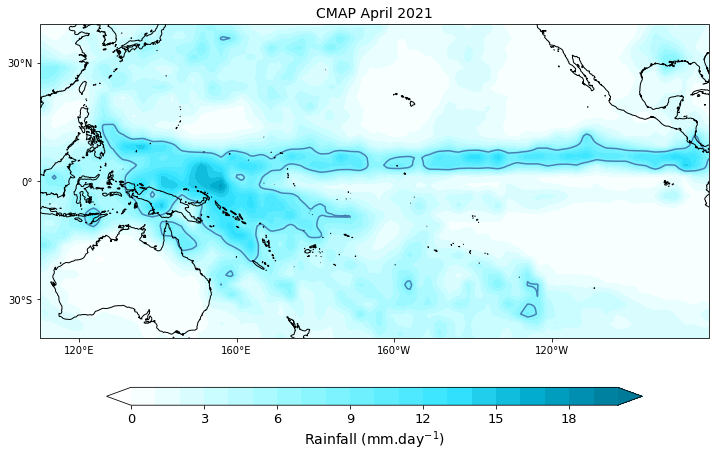

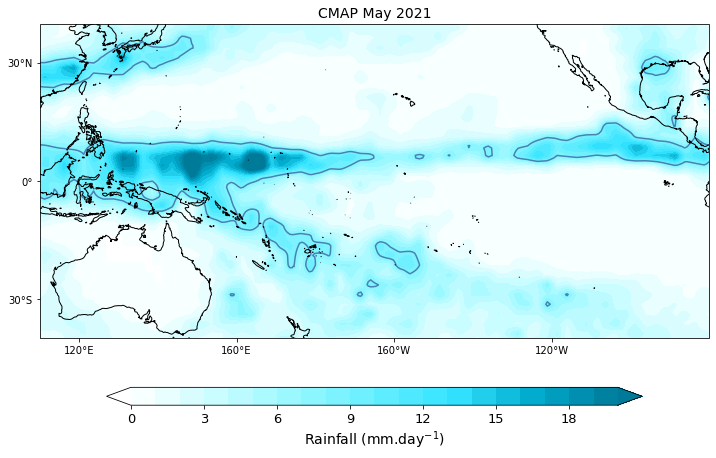

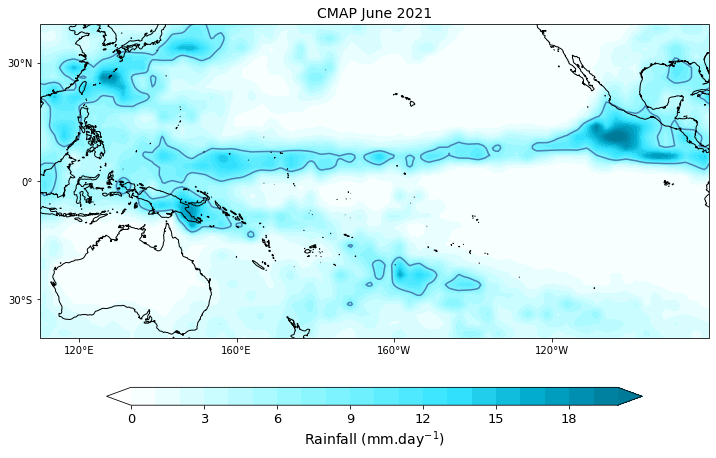

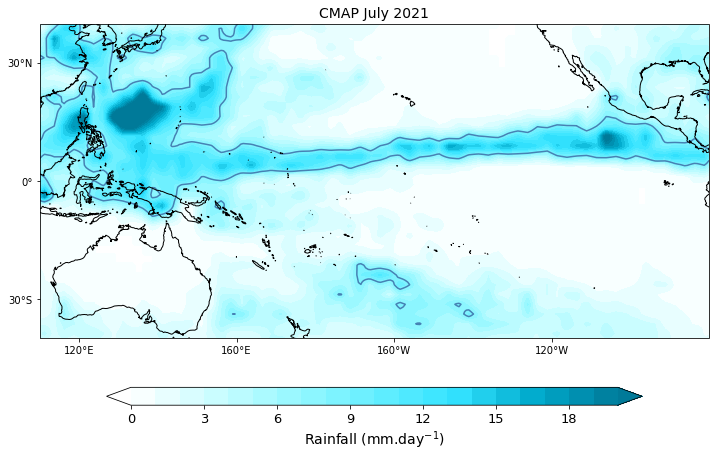

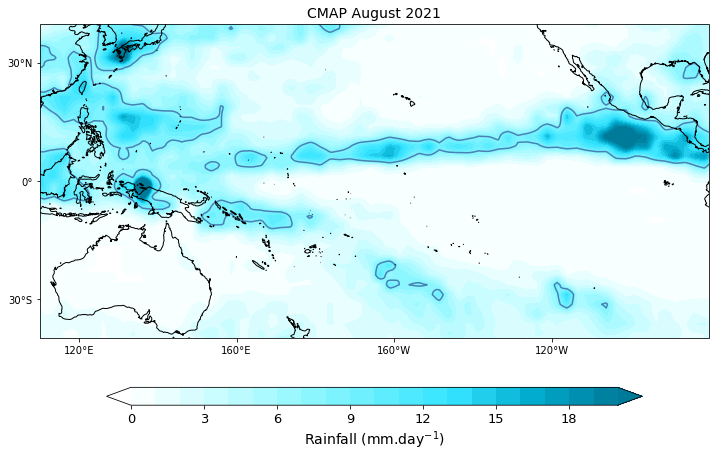

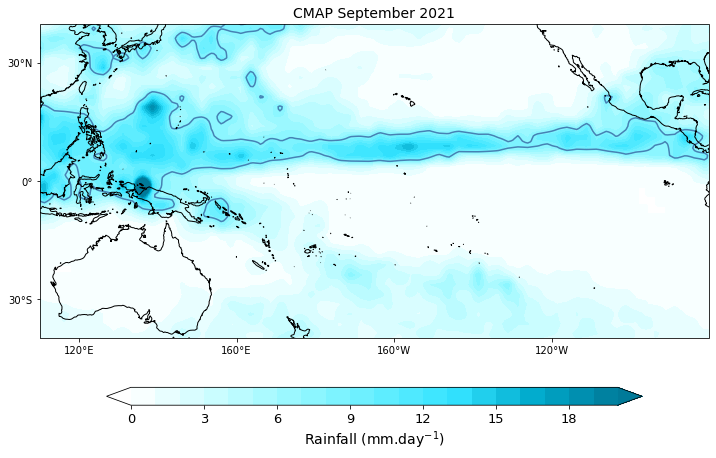

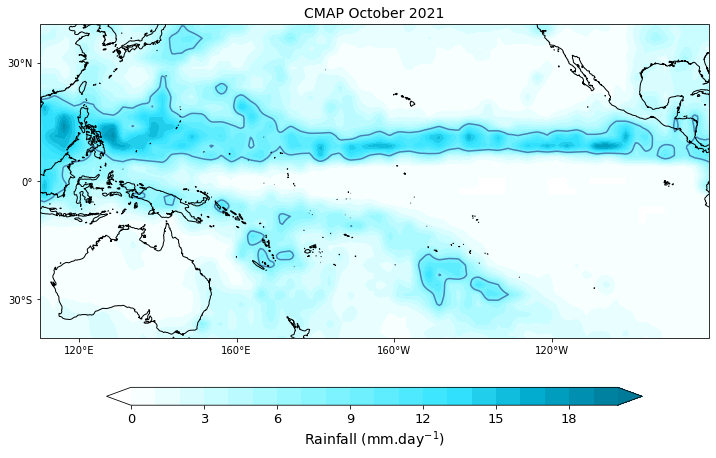

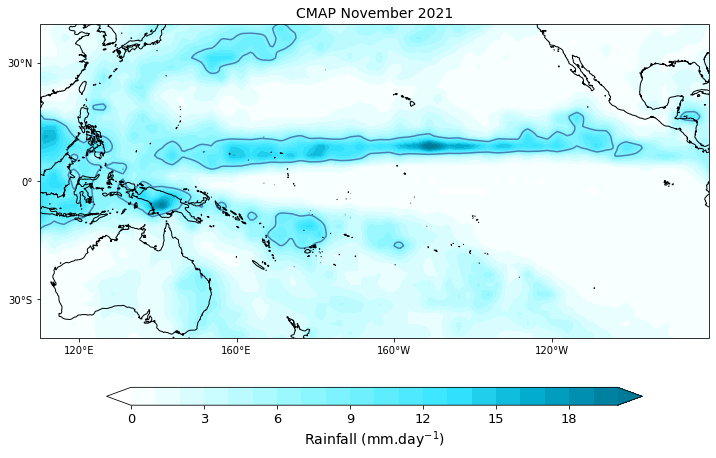

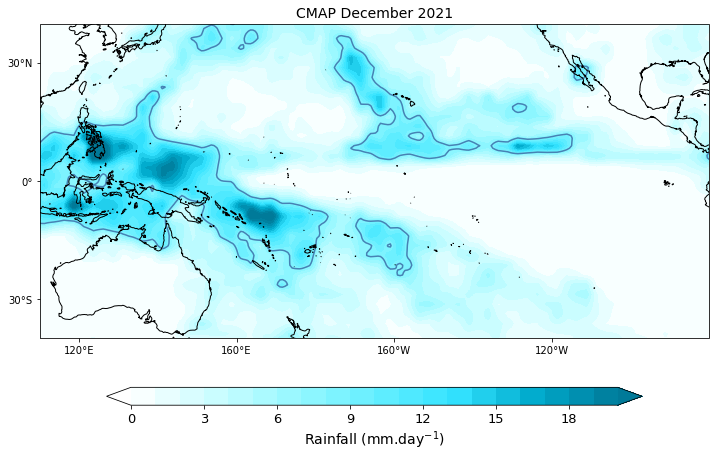

In [52]:
for date in pd.date_range(start='2021-01-01', end='2021-12-01', freq='MS'): 
    title = f"CMAP {date:%B %Y}"
    fname = f"../figures/CMAP_average_mm_{date:%Y-%m}_paper.png"
    plot_map(dset, date, varname=varname, title=title, fname=fname, units=units, cmap=cmap, vmin=vmin, vmax=vmax, step=step, contour=8, colors='steelblue')

### plots the climatology 

In [53]:
clim

<xarray.Dataset>
Dimensions:  (lat: 72, lon: 144, month: 12)
Coordinates:
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip   (month, lat, lon) float32 0.5167 0.5353 0.5497 ... nan nan nan

In [54]:
from calendar import month_abbr

In [55]:
vmin = 0
vmax = 16 
step = 2

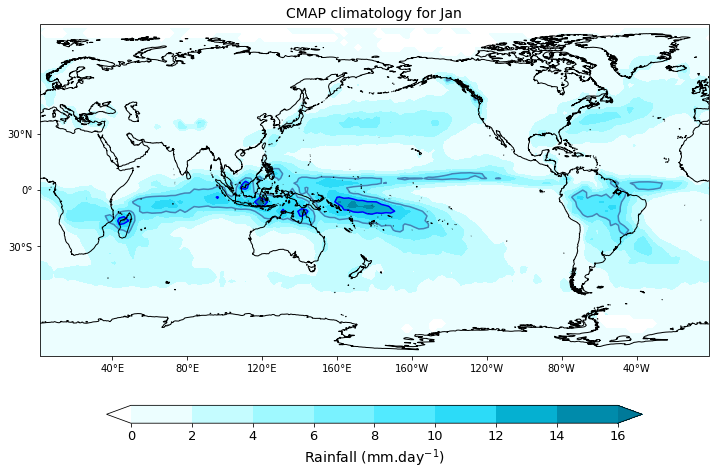

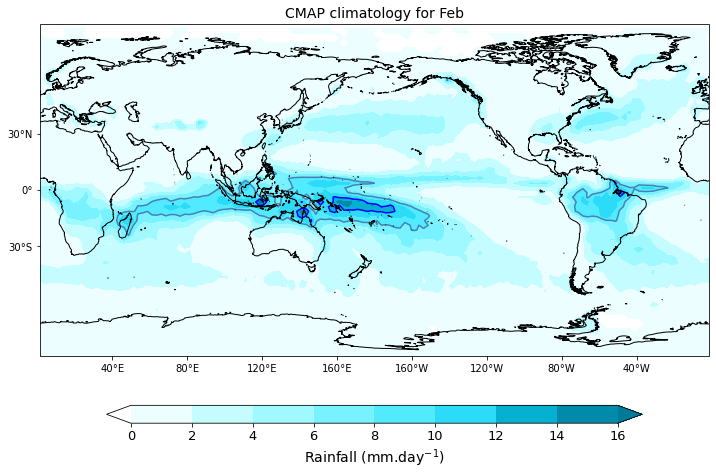

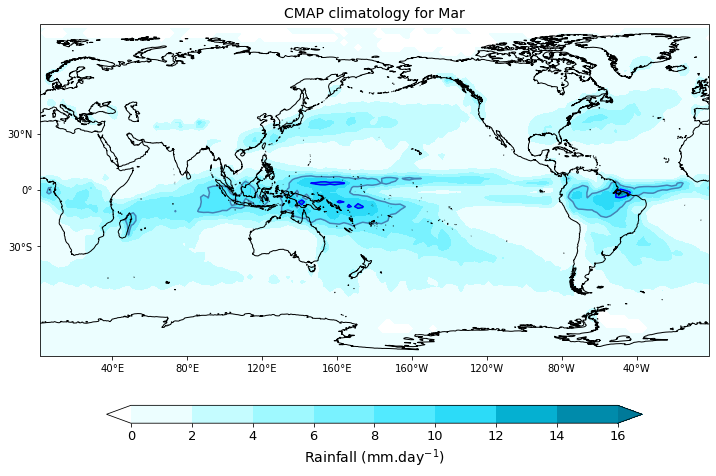

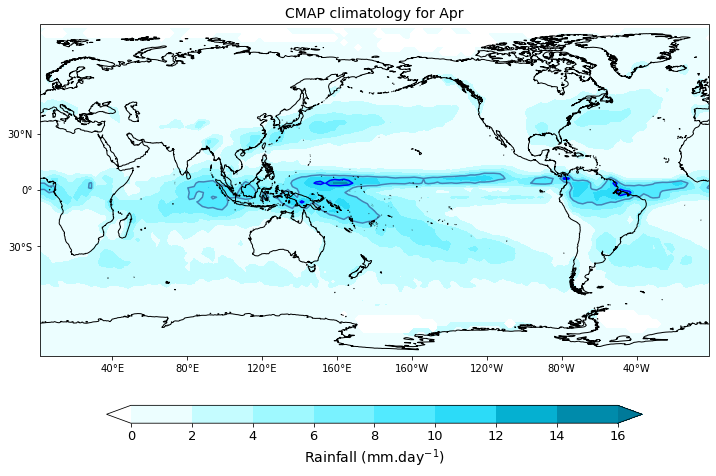

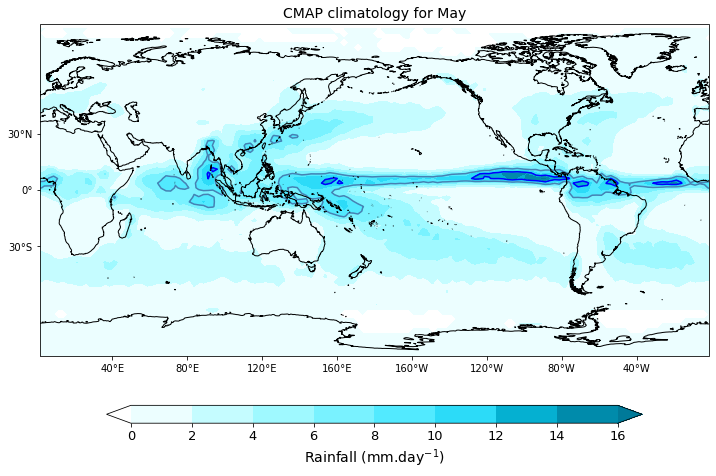

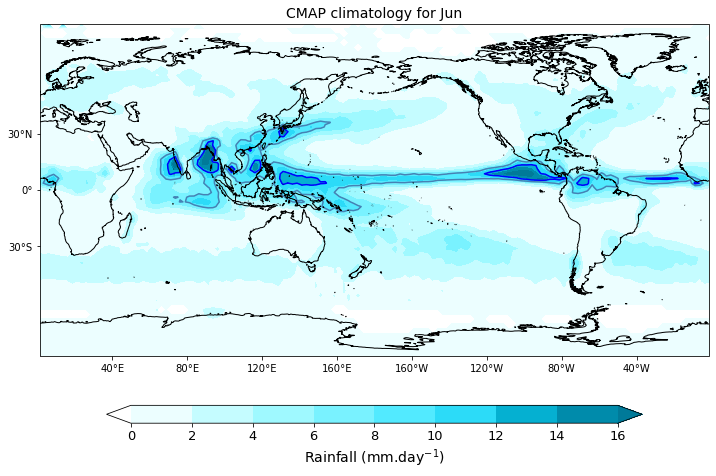

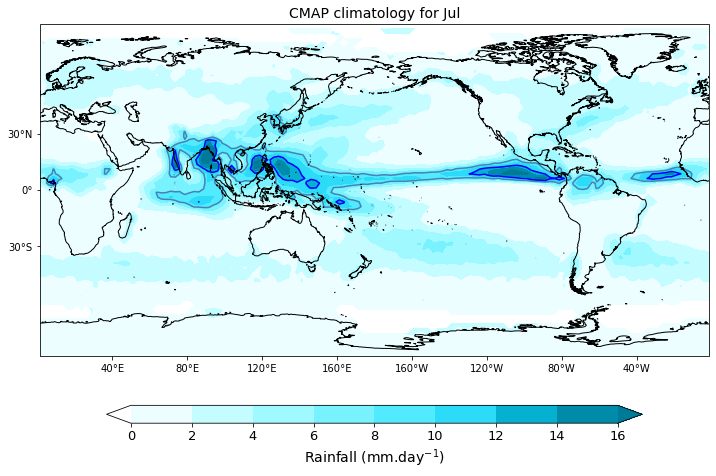

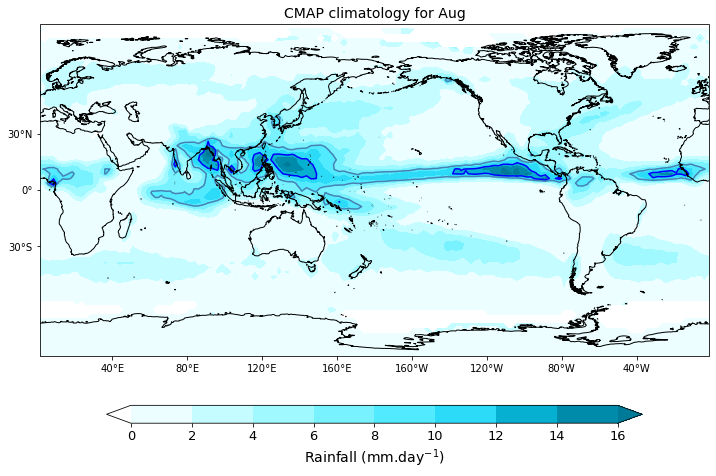

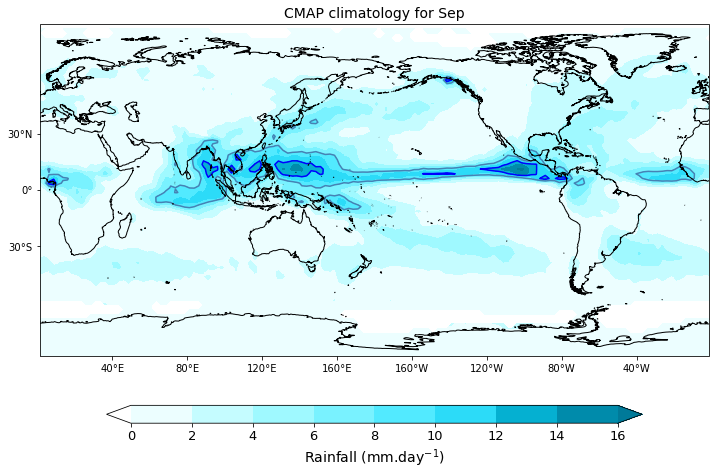

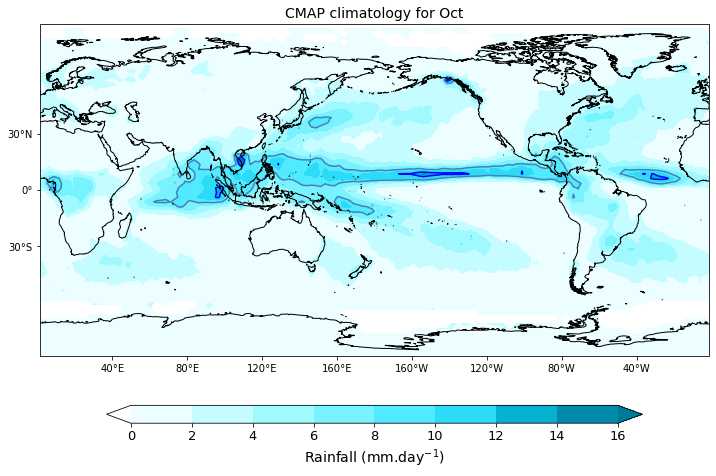

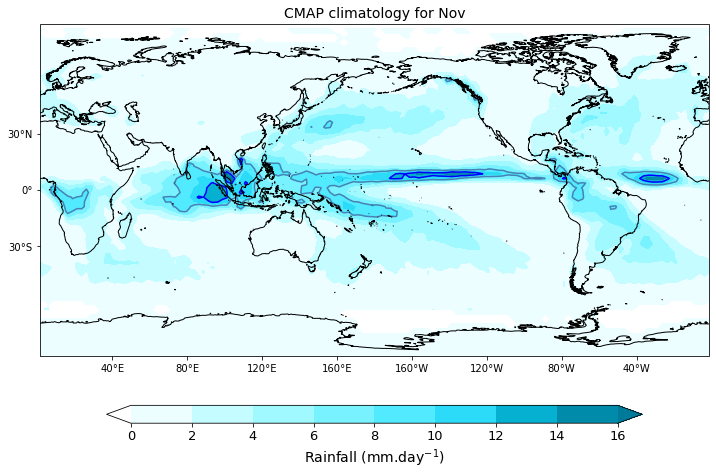

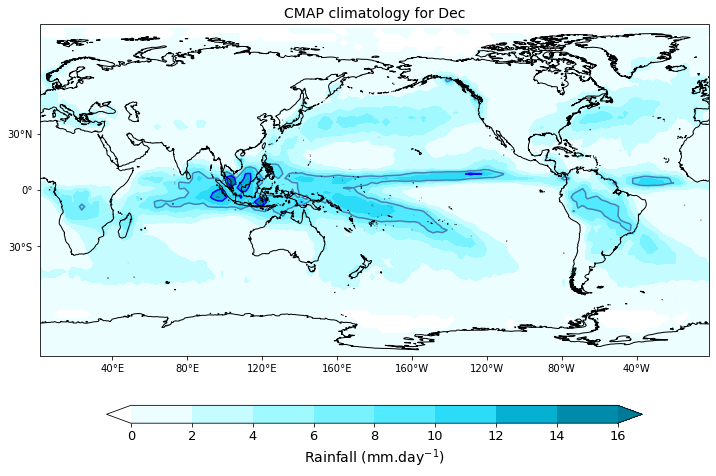

In [57]:
for month in range(1, 13): 
    title = f"CMAP climatology for {month_abbr[month]}"
    fname = f"../figures/CMORPH_climatology_mm_{month_abbr[month]}_paper.png"
    plot_clim(clim, month, varname=varname, title=title, fname=fname, units=units, cmap=cmap, vmin=vmin, vmax=vmax, step=step, contour=[8,12], colors=['steelblue','b'])